<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_PCA_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IoT-23 Data preprocessing
- Collection
- Cleaning
- Encoding
- Scaling
- Normalisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Step 1: Data Collection
#data_file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 8GB Dataset/Malware-Project/BigDataset/IoTScenarios/CTU-IoT-Malware-Capture-1-1/bro/conn.log.labeled'
# Read the file
# df = pd.read_csv(
#     data_file_path,
#     sep="\t",
#     comment="#",
#     header=None,
#     names=[
#         "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
#         "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
#         "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
#         "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "label"
#     ]
# )

#TEST:
# List of file paths
data_file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/Benign_Dataset13.csv',
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/DoS_Dataset21.csv',
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/GafgytBotnet_Dataset3.csv',
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/MiraiBotnet_Dataset1.csv',
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/MiraiVariant_Dataset5.csv',
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/OkiruBotnet_Dataset17.csv',
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/PartOfMioriBotnet_Dataset20.csv'

]
dfs = []#set the df list var

for file_path in data_file_paths: # Loop through the file paths and add the data to a temp df var
  try:
      temp_df = pd.read_csv(
          file_path,
          sep=",",
          comment="#",
          header=0,
          names=[
              "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
              "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
              "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
              "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "label"
          ]
      )
      dfs.append(temp_df) #add the info in the temp df to the dfs list
      print(f"Loaded file: {file_path} with {len(temp_df)} rows")
  except Exception as e:
      print(f"Error reading file {file_path}: {e}")

# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True) #make the list of dataframes into one big dataframe


print("\nInitial sample:")
print(df.head().to_string())

# Step 2: Data Cleaning
# Convert timestamp to datetime
df["ts"] = pd.to_datetime(df["ts"], unit="s", errors='coerce')

# Drop non-informative or redundant columns
df.drop(columns=['uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'history'], inplace=True)

# Replace '-' with NaN for consistent handling
df.replace('-', np.nan, inplace=True)

# Drop rows where critical numeric fields are missing
df.dropna(subset=[
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'
], inplace=True)

# Convert appropriate columns to numeric types
numeric_columns = [
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'missed_bytes'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Encode categorical columns
categorical_columns = ['proto', 'conn_state', 'service']
for col in categorical_columns:
    df[col] = df[col].astype(str)  # Ensure strings
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert label to binary (malicious=1, benign=0)
df['label'] = df['label'].apply(lambda x: 1 if 'Malicious' in str(x) else 0)

# Drop any rows still containing NaN
df.dropna(inplace=True)

print("\nCleaned sample:")
print(df.head().to_string())
print("\nData types and nulls:")
print(df.info())
# print("\nStatistics:")
# print(df.describe().to_string())


# --- Split features and labels ---
X = df.drop(columns=['label', 'ts']).values  # Drop label and timestamp
y = df['label'].values

# --- Normalize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- Add counts of malware and benign logs ---
total_logs = len(df)
malware_logs = df['label'].sum()  # since malware=1
benign_logs = total_logs - malware_logs

print(f"\nTotal logs: {total_logs}")
print(f"Malware logs: {malware_logs}")
print(f"Benign (non-malicious) logs: {benign_logs}")


Loaded file: /content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/Benign_Dataset13.csv with 4426 rows
Loaded file: /content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/DoS_Dataset21.csv with 3209 rows
Loaded file: /content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/GafgytBotnet_Dataset3.csv with 130 rows
Loaded file: /content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/MiraiBotnet_Dataset1.csv with 452 rows
Loaded file: /content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/MiraiVariant_Dataset5.csv with 10403 rows
Loaded file: /content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/OkiruBotnet_Dataset17.csv with 23145 rows
Loaded file: /content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/PartOfMioriBotnet_Dataset20.csv w

#Apply PCA

In [2]:
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10) #PCA will reduce the dimensionality of the data to exactly 10 features
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced {X_scaled.shape[1]} to {X_pca.shape[1]} components")

Reduced 13 to 10 components


# Data reshaping for 1D CNN input

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Step 1: Reshape the data for 1D CNN input
# --- 1D CNN expects input shape: (samples, timesteps, features) ---
# Here: timesteps = number of features, features = 1 (per timestep)
X_1dcnn = X_pca.reshape((X_pca.shape[0], X_pca.shape[1], 1))

#Step 2: Train/Validation/Test Split
# --- Split into Train/Val/Test ---
# Split test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_1dcnn, y, test_size=0.2, random_state=42, stratify=y)
# Split validation set (20% of remaining)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)
# Shuffle data:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# --- Final Shape Confirmation ---
print("1D CNN input shape:", X_1dcnn.shape)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels - Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

1D CNN input shape: (18003, 10, 1)
Train: (11521, 10, 1), Val: (2881, 10, 1), Test: (3601, 10, 1)
Labels - Train: [7428 4093], Val: [1857 1024], Test: [2322 1279]


#1D CNN model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

#Step 3: Define the 1D CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# Build model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(), #A layer in neural networks that normalizes the output of the previous layer
    MaxPooling1D(pool_size=2),
    Dropout(0.25), #TEST

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5), #TEST
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Train, Evaluate (Test) & Visualize 1D CNN

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8836 - loss: 0.2842 - val_accuracy: 0.9035 - val_loss: 0.4052
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9905 - loss: 0.0518 - val_accuracy: 0.9597 - val_loss: 0.0946
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9938 - loss: 0.0277 - val_accuracy: 0.9962 - val_loss: 0.0447
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9963 - loss: 0.0244 - val_accuracy: 0.9965 - val_loss: 0.0271
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9945 - loss: 0.0196 - val_accuracy: 0.9969 - val_loss: 0.0200
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9949 - loss: 0.0188 - val_accuracy: 0.9965 - val_loss: 0.0189
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.0238 - val_accuracy: 0.9969 - val_loss: 0.0153
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9964 - loss: 0.0173 - val_accuracy: 0

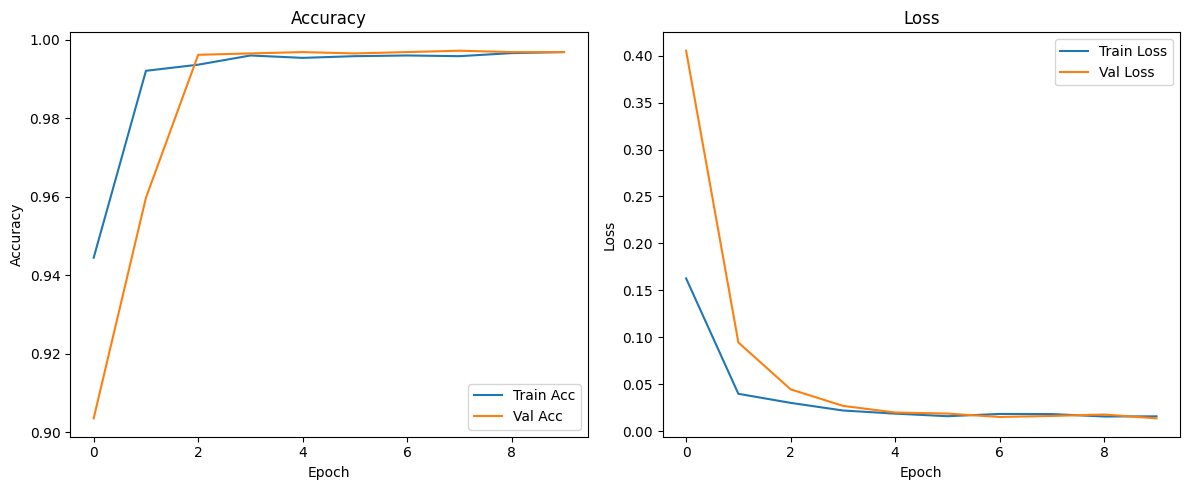

In [5]:
import matplotlib.pyplot as plt

#Step 4: Train the Model

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Step 5: Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


# Step 6: Plot Accuracy and Loss
plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy score
print("sklearn accuracy:", accuracy_score(y_test, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix:
[[2315    7]
 [   3 1276]]

True Negatives (Benign correctly classified): 2315
False Positives (Benign misclassified as malware): 7
False Negatives (Malware missed): 3
True Positives (Malware correctly identified): 1276
sklearn accuracy: 0.9972229936128854

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2322
   Malicious       0.99      1.00      1.00      1279

    accuracy                           1.00      3601
   macro avg       1.00      1.00      1.00      3601
weighted avg       1.00      1.00      1.00      3601



# 1D CNN Quant model

#Evaluate int8 1D CNN